# Requirements

In [1]:
import os
import json
import pandas as pd
import numpy as np
import json
import logging ### to monitor the code
from bs4 import BeautifulSoup
import xml.etree.cElementTree as ET
import pickle
import math
import random
import sys
import csv
import unicodedata
import requests
from urllib.request import urlopen 
import io
import getpass
import re
from collections import defaultdict
from itertools import islice # to iterate through dicts

import nltk
from nltk.collocations import *


### plotting
### to use latex (important for greek fonts)
#! apt-get install texlive-latex-recommended 
#! apt install texlive-latex-extra
#! apt install dvipng
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe
from google.oauth2 import service_account # based on google-auth library

import sddk

In [2]:
conf = sddk.configure("SDAM_root", "648597@au.dk")

sciencedata.dk username (format '123456@au.dk'): 648597@au.dk
sciencedata.dk password: ········
connection with shared folder established with you as its owner
endpoint variable has been configured to: https://sciencedata.dk/files/SDAM_root/


In [63]:
# to access gsheet, you need Google Service Account key json file
# I have mine located in my personal space on sciencedata.dk, so I read it from there:

# (1) read the file and parse its content
file_data = conf[0].get("https://sciencedata.dk/files/ServiceAccountsKey.json").json()
# (2) transform the content into crendentials object
credentials = service_account.Credentials.from_service_account_info(file_data)
# (3) specify your usage of the credentials
scoped_credentials = credentials.with_scopes(['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive'])
# (4) use the constrained credentials for authentication of gspread package
gc = gspread.Client(auth=scoped_credentials)

AGT_overview = gc.open_by_url("https://docs.google.com/spreadsheets/d/1iVta_FuEDgUM_Lf_yByrdbbXNoVH_dnVZs6QRyYv1NM/edit?usp=sharing")

CEMRAM_OVERVIEW = gc.open_by_url("https://docs.google.com/spreadsheets/d/1W5lBT2vxPXJZP06dRacNgEaM9wF9UlFnxiPq28vJJTg/edit?usp=sharing")

# AGT_metadata = gc.open_by_url("https://docs.google.com/spreadsheets/d/1hEUnL3E07F-EnE3wYnk1V91aXfPDrcnhFHKjD-04CM0/edit?usp=sharing")

In [4]:
# read the dataset
AGT = sddk.read_file("SDAM_data/AGT/AGT_20201020.json", "df", conf)

# Export latest data for improvement...

In [66]:
AGT.columns

Index(['filename', 'author', 'title', 'string', 'author_id', 'doc_id',
       'raw_date', 'date_avr', 'date_probs', 'date_manual', 'provenience',
       'wordcount', 'lemmata', 'lemmata_wordcount', 'lemmatized_sentences'],
      dtype='object')

In [ ]:
set_with_dataframe(CEMRAM_OVERVIEW.add_worksheet("works_overview", 1, 1), AGT.drop(["string", "lemmata", "lemmatized_sentences"], axis=1))

# A preliminary overview

In [5]:
len(AGT)

1403

In [6]:
### total number of words
AGT["wordcount"].sum()

34587206

In [7]:
len(AGT[AGT["date_avr"].notnull()])

1321

In [9]:
# number of documents before the end of the 4th c. CE

len(AGT[AGT["date_avr"].notnull()][AGT["date_avr"] < 4])

/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


1219

# Comparing different approaches to dating

In [15]:
AGT.head(5)

,filename,author,title,string,author_id,doc_id,raw_date,date_avr,date_probs,date_manual,provenience,wordcount,lemmata,lemmata_wordcount,lemmatized_sentences
0,tlg0001.tlg001.perseus-grc2.xml,Apollonius Rhodius,Argonautica; Argonautica,"ἀρχόμενος σέο, Φοῖβε, παλαιγενέων κλέα φωτῶν μ...",tlg0001,tlg0001.tlg001,3 B.C.,-2.5,{'-2.5': 1},-2.5,pagan,38822,"[σέο, φοῖβος, παλαιγενής, κλέος, φάος, μιμνήσκ...",24237,"[[σέο, φοῖβος, παλαιγενής, κλέος, φάος, μιμνήσ..."
1,tlg0003.tlg001.perseus-grc2.xml,Thucydides,The Peloponnesian War; Historiae in two volumes,Θουκυδίδης Ἀθηναῖος ξυνέγραψε τὸν πόλεμον τῶν ...,tlg0003,tlg0003.tlg001,5 B.C.,-4.5,{'-4.5': 1},-4.5,pagan,150160,"[θουκυδίδης, Ἀθηναῖος, συγγράφω, πόλεμος, Πελο...",68166,"[[θουκυδίδης, Ἀθηναῖος, συγγράφω, πόλεμος, Πελ..."
2,tlg0004.tlg001.perseus-grc1.xml,Diogenes Laertius,Lives of Eminent Philosophers; Lives of Eminen...,ΒΙΩΝ ΚΑΙ ΓΝΩΜΩΝ ΤΩΝ ΕΝ ΦΙΛΟΣΟΦΙΑΙ ΕΥΔΟΚΙΜΗΣΑΝΤ...,tlg0004,tlg0004.tlg001,A.D. 3,2.5,{'2.5': 1},NaN,,111053,"[βία, ἀκή, γνώμη, ἕνος, φιλοσοφία, εὐδοκιμέω, ...",55580,"[[βία, ἀκή, γνώμη, ἕνος, φιλοσοφία, εὐδοκιμέω,..."
3,tlg0005.tlg001.perseus-grc1.xml,Theocritus,Idylls ; Idylls,Θύρσις ἢ ᾠδή Θύρσις ̔Αδύ τι τὸ ψιθύρισμα καὶ ἁ...,tlg0005,tlg0005.tlg001,4-3 B.C.,-3.0,"{'-3.5': 0.5, '-2.5': 0.5}",NaN,,19514,"[θύρσις, ἀοιδή, θύρσις, αδύ, ψιθύρισμα, πίτυς,...",12478,"[[θύρσις, ἀοιδή, θύρσις, αδύ, ψιθύρισμα, πίτυς..."
4,tlg0005.tlg002.perseus-grc1.xml,Theocritus,Epigrams ; Idylls,α παλ ϝι.336 τὰ ῥόδα τὰ δροσόεντα καὶ ἁ κατάπυ...,tlg0005,tlg0005.tlg002,4-3 B.C.,-3.0,"{'-3.5': 0.5, '-2.5': 0.5}",NaN,,1807,"[παλ, ϝι, ῥοδῆ, δροσόεντα, κατάπυκνος, ἐκεῖνος...",1137,"[[παλ, ϝι], [ῥοδῆ, δροσόεντα, κατάπυκνος, ἐκεῖ..."


In [10]:
centuries = [num + 0.5 for num in range(-8, 4)]
centuries

[-7.5, -6.5, -5.5, -4.5, -3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5]

In [11]:
dates = [num /10 for num in range(-75, 40, 5)]
print(dates)

[-7.5, -7.0, -6.5, -6.0, -5.5, -5.0, -4.5, -4.0, -3.5, -3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5]


In [21]:
AGT["date_probs"].tolist()[0]["-2.5"]

1

In [38]:
centuries_aor = {}
def get_prob(x):
    try: return x[str(century)]
    except: return 0
for century in centuries:
    centuries_aor[century] =  AGT["date_probs"].apply(get_prob).sum()
centuries_aor

{-7.5: 6.8331,
 -6.5: 3.8331,
 -5.5: 8.8331,
 -4.5: 135.0,
 -3.5: 228.5,
 -2.5: 39.25,
 -1.5: 12.958400000000001,
 -0.5: 38.8959,
 0.5: 163.8647,
 1.5: 437.5991,
 2.5: 74.9664,
 3.5: 67.9003}

In [39]:
centuries_aor_df = pd.DataFrame(centuries_aor, index=[0]).T[:6]
centuries_aor_df

,0
-7.5,6.8331
-6.5,3.8331
-5.5,8.8331
-4.5,135.0000
-3.5,228.5000
-2.5,39.2500
-1.5,12.9584
-0.5,38.8959
0.5,163.8647
1.5,437.5991


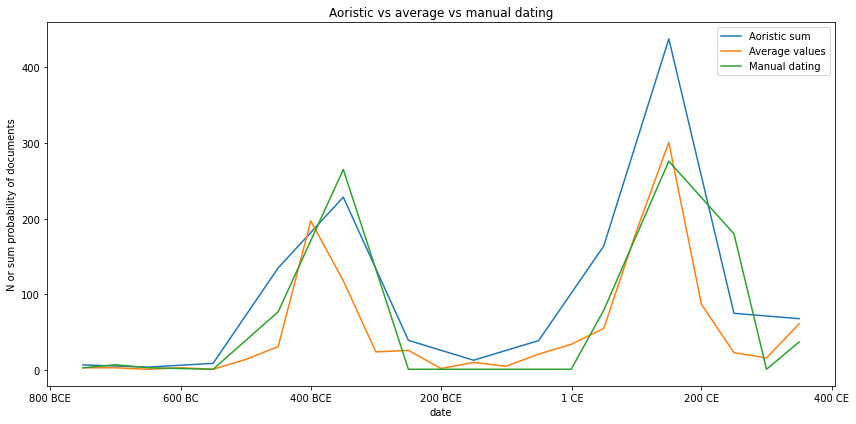

In [60]:
### documents with probabilities
fig, ax = plt.subplots(figsize=(12, 6), tight_layout=True)

centuries_aor_df.plot(ax=ax)
AGT.groupby("date_avr").size()[:3.5].plot(ax=ax)
AGT.groupby("date_manual").size()[:3.5].plot(ax=ax)
ax.set_xlabel("date")
ax.set_ylabel("N or sum probability of documents")
ax.set_xticks([-8, -6, -4, -2, 0.01, 2, 4])
ax.set_xticklabels(["800 BCE", "600 BC", "400 BCE", "200 BCE", "1 CE", "200 CE", "400 CE"])

plt.title("Aoristic vs average vs manual dating")
plt.legend(labels=["Aoristic sum", "Average values", "Manual dating"])

In [62]:
sddk.write_file("SDAM_data/AGT/AGT_dating_overview_20201026.png", fig, conf)

Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/AGT/AGT_dating_overview_20201026.png"


# Overview of authors

In [49]:
authors = []
for author_id in AGT["author_id"].unique().tolist():
  author_df = AGT[AGT["author_id"]==author_id]
  try: author = "/".join(author_df["author"].unique().tolist())
  except: author = author_df["author"].unique().tolist()[0]
  wordcount = author_df["wordcount"].sum()
  provenience = author_df["provenience"].unique().tolist()[0]
  date = author_df["date_avr"].unique().tolist()[0]
  author_data = [author_id, author, provenience, date, len(author_df), wordcount]
  authors.append(author_data)

In [50]:
authors_df = pd.DataFrame(authors)
authors_df.columns = ["author id", "name", "provenience", "date", "N of works", "N of words"]
authors_df.head(5)

,author id,name,provenience,date,N of works,N of words
0,tlg0001,Apollonius Rhodius,pagan,-2.5,1,38822
1,tlg0003,Thucydides,pagan,-4.5,1,150160
2,tlg0004,Diogenes Laertius,,2.5,1,111053
3,tlg0005,Theocritus,,-3.0,2,21321
4,tlg0006,Euripides,pagan,-4.5,13,112900


In [51]:
len(authors_df)

258

In [172]:
set_with_dataframe(AGT_overview.add_worksheet("authors_overview_20201019", rows=1, cols=1), authors_df)

# Wordcounts overview

In [74]:
dates

[-7.5,
 -7.0,
 -6.5,
 -6.0,
 -5.5,
 -5.0,
 -4.5,
 -4.0,
 -3.5,
 -3.0,
 -2.5,
 -2.0,
 -1.5,
 -1.0,
 -0.5,
 0.0,
 0.5,
 1.0,
 1.5,
 2.0,
 2.5,
 3.0,
 3.5]

In [70]:
def date_avr_to_string(date):
    if str(date)[-1]=="5":
        date_number = str(int(abs(date) + 0.5))
       
    else: 
        if date < 0:
            date_number = str(int(abs(date) + 1))  + "/" + str(int(abs(date)))
        else: 
            date_number = str(int(abs(date)))  + "/" + str(int(abs(date) + 1))
    if date < 0: date_string = date_number + " BCE"
    else: date_string = date_number + " CE"
    if date == 0.0:
        date_string = "1 BCE/1 CE"
    return date_string

In [73]:
subselections = []
for date in dates:
    subselection = AGT[AGT["date_avr"]== date]
    wordcount_christian = AGT[(AGT["date_avr"]== date) & (AGT["provenience"]=="christian")]["wordcount"].sum()
    wordcount_pagan = AGT[(AGT["date_avr"]== date) & (AGT["provenience"]!="christian")]["wordcount"].sum()
    wordcount = subselection["wordcount"].sum()
    sentences = subselection["lemmatized_sentences"].apply(lambda x: len(x)).sum()
    doccount = len(subselection)
    date_string = date_avr_to_string(date)
    subselection_dict = {"date_string" : date_string, "column" : "date_avr", "value" : date, "wordcount" : wordcount, "sentences" : sentences, "wordcount_christian" : wordcount_christian, "wordcount_pagan" : wordcount_pagan, "doccount": doccount}
    subselections.append(subselection_dict)
subselections_df = pd.DataFrame(subselections)
subselections_df

,date_string,column,value,wordcount,sentences,wordcount_christian,wordcount_pagan,doccount
0,8 BCE,date_avr,-7.5,199840,15208,0,199840,3
1,8/7 BCE,date_avr,-7.0,16193,1183,0,16193,3
2,7 BCE,date_avr,-6.5,146,13,0,146,1
3,7/6 BCE,date_avr,-6.0,9326,694,0,9326,3
4,6 BCE,date_avr,-5.5,44243,3768,0,44243,1
5,6/5 BCE,date_avr,-5.0,68050,6036,0,68050,14
6,5 BCE,date_avr,-4.5,538722,36013,0,538722,31
7,5/4 BCE,date_avr,-4.0,1563911,108639,0,1563911,197
8,4 BCE,date_avr,-3.5,1298791,77695,0,1298791,118
9,4/3 BCE,date_avr,-3.0,190927,14881,0,190927,24


/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


Text(0.5, 1.0, 'Corpus overview')

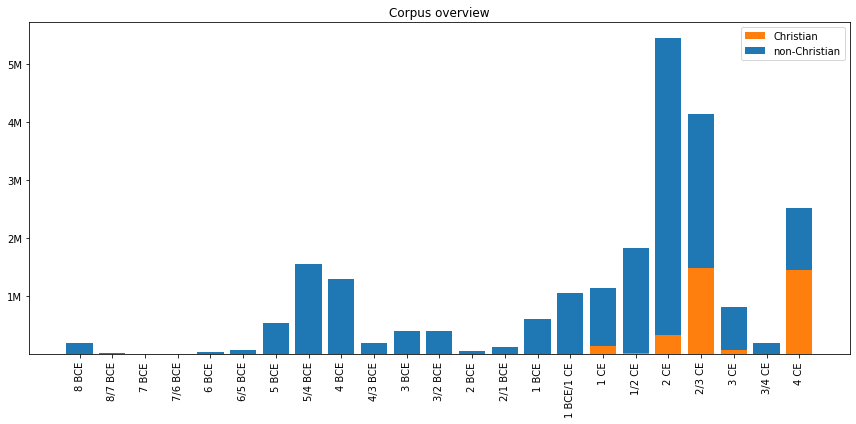

In [75]:
fig, ax = plt.subplots(figsize=(12, 6), tight_layout=True)
#subselections_df = subselections_df.iloc[::-1]
ax.bar(subselections_df["date_string"], subselections_df["wordcount_christian"], color="tab:orange", label="Christian")
ax.bar(subselections_df["date_string"], subselections_df["wordcount_pagan"], bottom=subselections_df["wordcount_christian"], label="non-Christian", color="tab:blue")


ax.set_yticks(range(1000000,6000000, 1000000))
ax.set_yticklabels(str(n) + "M" for n in range(1,6))
ax.set_xticklabels(subselections_df["date_string"], rotation=90)
ax.legend()
plt.title("Corpus overview")

In [ ]:
sddk.write_file("SDAM_data/AGT/AGT_corpus_overview.png")

In [85]:
subcorpora_dict = {# main subcorpora
    "Archaic (8-6 BCE)" : AGT[(AGT["provenience"]=="pagan") & (AGT["date_avr"] <= -5.5)],
    "Classical (5-4 BCE)" : AGT[(AGT["provenience"]=="pagan") & (AGT["date_avr"].between(-5, -3))],
    "Non-Christian (1-4 CE)" : AGT[(AGT["date_avr"].between(0, 4)) & (AGT["provenience"]=="pagan")],
    "Christian (1-4 CE)" : AGT[(AGT["date_avr"] < 4) & (AGT["provenience"]=="christian")]}
   
subcorpora_dict_other = {
    # other relevant subcorpora (some overlaps)
    "Pagan (8th c. BCE - 4th c. CE)" : AGT[(AGT["provenience"]=="pagan") & (AGT["date_avr"] < 4)],
    "Pagan (1st - 4th c. CE)" : AGT[(AGT["date_avr"].between(0, 4)) & (AGT["provenience"]=="pagan")],
    "Septuagint" : AGT[AGT["author_id"]=="tlg0527"],
    "Philo of Alexandria" : AGT[AGT["author_id"]=="tlg0018"],
    "Titus Flavius Josephus" : AGT[AGT["author_id"]=="tlg0526"],
    "Paul of Tarsus" : AGT[AGT["author_id"]=="tlg0031paul"],
    "New Testament" : AGT[AGT["author_id"].str.startswith("tlg0031")],
    "Christian (1st - 4th c. CE)" : AGT[(AGT["date_avr"] < 4) & (AGT["provenience"]=="christian")]}

In [86]:
subselections = []
for key in subcorpora_dict.keys():
    subselection = subcorpora_dict[key]
    subselection_dict = {}
    wordcount = subselection["wordcount"].sum()
    doccount = len(subselection)
    sentences = subselection["lemmatized_sentences"].apply(lambda x: len(x)).sum()
    subselection_dict.update({"label" : key, "wordcount" : wordcount, "doccount" : doccount, "sentences" : sentences})
    subselections.append(subselection_dict)
subselections_df = pd.DataFrame(subselections)
subselections_df

,label,wordcount,doccount,sentences
0,Archaic (8-6 BCE),269748,11,20866
1,Classical (5-4 BCE),3407824,331,224933
2,Non-Christian (1-4 CE),9448494,409,546012
3,Christian (1-4 CE),3521122,131,171376
